## Configs

In [1]:
#Pip installation

# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# # !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install albumentations==0.4.6
# !pip install opencv-python-headless==4.5.2.52

In [2]:
import torch
import matplotlib.pyplot as plt

from application.src.config import DEVICE, NUM_CLASSES, VISUALIZE_TRANSFORMED_IMAGES, NUM_EPOCHS, SAVE_MODEL_EPOCH, SAVE_PLOTS_EPOCH, OUT_DIR
from application.src.models.custom_dataset import train_loader, valid_loader
from application.src.models.faster_rcnn import RCNNModel
from application.src.utils.timer import Timer
from application.src.utils import Averager

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [3]:
def train(train_data_loader, model) -> list[int]:
    """
    Training method for our RCNN-model
    :param train_data_loader: Dataloader;
    :param model: FasterRCNN;
    :return: list[int];
    """
    global train_itr
    global train_loss_list

    print('Training the model')

    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        prog_bar.set_description(desc=f'Loss: {loss_value:.4f}')

    return train_loss_list


def validate(valid_data_loader, model) -> list[int]:
    """
    Method to validate the data in our RCNN-model
    :param valid_data_loader: Dataloader;
    :param model: FasterRCNN;
    :return: list[int];
    """
    print('Validating the model data')
    global val_itr
    global val_loss_list

    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1

        prog_bar.set_description(desc=f'Loss: {loss_value:.4f}')

    return val_loss_list


# Faster - RCNN model

Training the model


EPOCH 1 of 2
Training the model


  0%|          | 0/1668 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (450) must match the size of tensor b (3) at non-singleton dimension 0

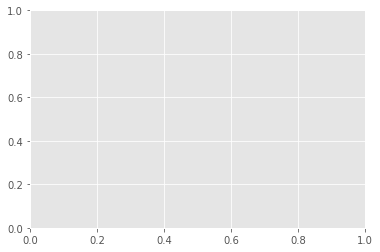

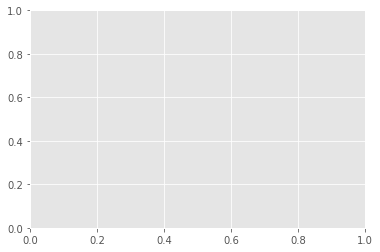

In [4]:
model = RCNNModel()

params = [p for p in model.model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

train_loss_hist = Averager()
val_loss_hist = Averager()

train_itr, val_itr = 1, 1
train_loss_list, val_loss_list = [], []

if VISUALIZE_TRANSFORMED_IMAGES:
    from application.src.utils.transform import show_transformed_image

    show_transformed_image(train_loader)

timer = Timer()

for epoch in range(NUM_EPOCHS):
    print(f'\nEPOCH {epoch + 1} of {NUM_EPOCHS}')
    train_loss_hist.reset()
    val_loss_hist.reset()

    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    timer.start()

    train_loss = train(train_loader, model.model)
    val_loss = validate(valid_loader, model.model)
    print(f'Epoch #{epoch} train loss: {train_loss_hist.value:.3f}')
    print(f'Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}')

    if (epoch + 1) % SAVE_MODEL_EPOCH == 0:
        torch.save(model.model.state_dict(), f'{OUT_DIR}/model{epoch + 1}.pth')
        print('SAVING MODEL COMPLETE...\n')

    if (epoch + 1) % SAVE_PLOTS_EPOCH == 0:
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f'{OUT_DIR}/train_loss_{epoch + 1}.png')
        figure_2.savefig(f'{OUT_DIR}/valid_loss_{epoch + 1}.png')
        print('SAVING PLOTS COMPLETE...')

    if (epoch + 1) == NUM_EPOCHS:
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f'{OUT_DIR}/train_loss_{epoch + 1}.png')
        figure_2.savefig(f'{OUT_DIR}/valid_loss_{epoch + 1}.png')
        torch.save(model.model.state_dict(), f"{OUT_DIR}/model{epoch + 1}.pth")

    plt.close('all')

    timer.stop()